## Copyright 2019 Google LLC.

In [ ]:
#@title
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a id='sect0'></a>
## <font color='darkblue'>4. Deep Q-Learning</font>
* <font size='3ptx'><b><a href='#sect1'>Define Neural Network</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Calculate Q-Values from Neural Network</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Implement Framework to Solve Frozen Lake</a></b></font>
* <font size='3ptx'><b><a href='#sect4'>Train Agent to Solve Frozen Lake</a></b></font>
* <font size='3ptx'><b><a href='#sect5'>Visualize Performance of Trained Model</a></b></font>
* <font size='3ptx'><b><a href='#sect6'>Conclusion and Next Steps</a></b></font>

In this Colab, you will combine Q-learning with neural networks to create a powerful technique, called Deep Q-Learning (DQN).

### <font color='darkgreen'>Motivation</font>

In the last Colab, you learned tabular Q-learning. Your Q-table required an entry for every combination of state and action. However, <b>for complex environments that have many states and actions, the Q table's size becomes massive. Instead of a Q-table, you can predict Q-values using a neural network. This application of deep learning to Q-learning is called <font color='darkblue'>DQN</font>.</b>

### <font color='darkgreen'>Setup</font>

Run the following cell to set up Google Analytics for the Colab. Data from  Google Analytics helps improve the Colab.

In [1]:
#@title Set up Google Analytics for Colab
%reset -f
import uuid
client_id = uuid.uuid4()

import requests

# Bundle up reporting into a function.
def report_execution():
  requests.post('https://www.google-analytics.com/collect', 
                data=('v=1'
                      '&tid=UA-48865479-3'
                      '&cid={}'
                      '&t=event'
                      '&ec=cell'            # <-- event type
                      '&ea=execute'         # <-- event action
                      '&el=rl-deep-q-learning'   # <-- event label
                      '&ev=1'               # <-- event value
                      '&an=bundled'.format(client_id)))

from IPython import get_ipython
get_ipython().events.register('post_execute', report_execution)

In [3]:
#!pip install tensorflow

Run the following cell to import libraries and set up the environment:

In [36]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

EPSILON_MIN = 0.01
CHECK_SUCCESS_INTERVAL = 20

env = gym.make('FrozenLake-v0')

num_states = env.observation_space.n
num_actions = env.action_space.n

<a id='sect1'></a>
## <font color='darkblue'>Define Neural Network</font>

You will implement the same epsilon-greedy policy environment. However, **instead of storing Q-values in a table, you will use a neural network to generate the Q-values**.

The input to the neural net is the state. In FrozenLake, represent the state using [one-hot encoding](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering). For example, encode the state `10` by running the following code (<a href='https://numpy.org/doc/stable/reference/generated/numpy.identity.html'><b>numpy</b>.identity</a>):

In [3]:
np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [4]:
np.identity(3)[2:3]

array([[0., 0., 1.]])

In [5]:
np.identity(num_states)[10:10+1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Define a function to create encode states as one-hot vectors:

In [6]:
def one_hot_encode_state(state):
    """One hot encoding for given state
  
    Args:
        state: An integer representing the agent's state.

    Returns:
        A one-hot encoded vector of the input `state`.
    """
    return(np.identity(num_states)[state:state+1])

The input to the neural net is a vector of length 16. The output is a vector of Q-values for each action. Since there are 4 actions, the output is a vector of length 4.

Define a nonlinear neural net with 16 inputs and 4 outputs by using the <a href='https://www.tensorflow.org/api_docs/python/tf/keras'><b>TF Keras API</b></a>. The neural net has these characteristics:

* Uses <a href='https://keras.io/api/layers/activations/#relu-function'><b>`relu`</b></a> activation function.
* Is initialized with small positive weights. Ideally, you should use known good initial values for the weights. The initialization with positive values is a workaround.
* Does not use biases. To understand why, suppose you used biases. Now, for an input $s_1$, the neural network predicts $Q(s_1,a_1)$ by transforming $s_1$ to $f(s_1)$. Then the output neuron for $a_1$ adds a bias, $b_{a_{1}}$,  as follows:
$$Q(s_1,a_1) = f(s_1) + b_{a_{1}}$$
Similarly, for state $s_2$, the prediction $Q(s_2,a_1)$ adds the same bias $b_{a_{1}}$ because the action (and thus the output neuron) remains the same:
$$Q(s_2,a_1) = f(s_2) + b_{a_{1}}$$
Therefore, for the same action, Q-value predictions depend on the same bias, even if the input state varies. Training to predict the Q-value for $(s_1,a_1)$ will change $b_{a_1}$. However, changing $b_{a_1}$ will change the predicted Q-values for $(s_2,a_1)$, resulting in wrong Q-values. Therefore, do not use biases.

Complete the neural net definition in the following cell as described. Then run the cell. For the solution, view the next cell.

In [7]:
#@title Solution (double-click to view code)
def define_model(learning_rate, num_actions, num_states):
    '''Returns a shallow neural net defined using tf.keras.
    Args:
        learning_rate: optimizer learning rate
        num_actions: number of action available
        num_states: number of states
        
    Returns:
        model: A shallow neural net defined using tf.keras input dimension equal to
            num_states and output dimension equal to num_actions.
    '''
    model = keras.Sequential()
    model.add(keras.layers.Dense(
                units = num_actions,
                input_dim = num_states,
                activation = 'relu',
                use_bias = False,
                kernel_initializer = keras.initializers.RandomUniform(minval=1e-5, maxval=0.05)))
    
    model.compile(optimizer = keras.optimizers.SGD(lr = learning_rate), loss = 'mse')
    return(model)

learning_rate = 0.1
model = define_model(learning_rate, num_actions, num_states)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 64        
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


2021-09-20 20:13:59.878194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-20 20:13:59.878235: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-20 20:13:59.878262: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2021-09-20 20:13:59.878482: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/root/Github/ml_courses/env/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr

<a id='sect2'></a>
## <font color='darkblue'>Calculate Q-Values from Neural Network</font>

You can use your neural network to predict Q-values for any state. For example, predict Q-values for state 5 by running the following cell. Since your neural network has not been trained, these predicted Q-values are inaccurate.

In [8]:
action_prediction = model.predict(one_hot_encode_state(5))
action_prediction

2021-09-20 20:14:04.686835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[0.0276859 , 0.02281187, 0.02484266, 0.02436265]], dtype=float32)

In [9]:
np.argmax(action_prediction)

0

Complete the following cell to implement a function (<font color='brown'>identical to the previous Colab</font>) that returns an action using an epsilon greedy policy. Then run the cell. For the solution, view the next cell.

In [10]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
def policy_eps_greedy(env, q_values, epsilon):
    """Select action given Q-values using epsilon-greedy algorithm.
    Args:
        q_values: q_values for all possible actions from a state.
        epsilon: Current value of epsilon used to select action using epsilon-greedy algorithm.
        
    Returns:
        action: action to take from the state.
    """
    if(np.random.rand() < epsilon):
        action = env.action_space.sample()
    else:
        action = np.argmax(q_values)
    return action

<b>In deep Q-learning, the neural network replaces the Q-table.</b> To demonstrate how, run a full training step using the neural network.

First, reset the environment and calculate Q-values for the starting state:

In [11]:
state = env.reset()
q_values = model.predict(one_hot_encode_state(state))

print("Q-values for state " + str(state) + " :\n" + str(q_values))

Q-values for state 0 :
[[0.01103142 0.04524688 0.01235563 0.03179582]]


Each Q-value represents the approximated return from taking the corresponding action and then following a greedy policy. Therefore, when Q-values are accurate, choosing the action with the highest Q-value will maximize return.

Using the Q-values, select an action using an epsilon-greedy policy. Take the action and record the next state and reward.

In [12]:
epsilon = 0.5 # assume some value of epsilon

action = policy_eps_greedy(env, q_values, epsilon)
state_new, reward, _, _ = env.step(action)

print("action:", action, ", next state:", state_new, ", reward:", reward)

action: 1 , next state: 4 , reward: 0.0


Calculate the target Q-value by completing the following cell to define a function. The formula for the returned Q-value is:

$$
  r(s,a)
      + \gamma \displaystyle \max_{\substack{a_1}} Q(s_1,a_1)
$$

This function is similar to the Bellman update in the previous Colab, except for the use of a neural network.

In [13]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
def bellman_update(reward, discount_factor, model, state_new):
    return reward + discount_factor * np.max(model.predict(one_hot_encode_state(state_new)))

Calculate target Q-values by calling the function `bellman_update`:

In [14]:
discount_factor = 0.99

print("Q-values before update for state " + str(state) + " :\n" + str(q_values))
target_q_values = q_values
target_q_values[0, action] = bellman_update(reward, discount_factor, model, state_new)

print("Q-values after update for state " + str(state) + " :\n" + str(target_q_values))

Q-values before update for state 0 :
[[0.01103142 0.04524688 0.01235563 0.03179582]]
Q-values after update for state 0 :
[[0.01103142 0.04307545 0.01235563 0.03179582]]


Notice that only the Q-value corresponding to the action taken changes after the update. The updated Q-values become the "target" label that the neural network uses to train.

Train the neural network to predict the target Q-values:

In [15]:
model.fit(one_hot_encode_state(state), target_q_values, verbose = True)

1/1 [==============================] - 0s 135ms/step - loss: 1.1788e-06


To summarize, in each state, train the neural network by following these steps:

1. Choose an action using an epsilon-greedy policy, using the neural network to predict Q-values.
1. Take the action and record the next state and reward.
1. Calculate a target Q-value for the $(s,a)$ pair using the Bellman update.
1. Train the neural network to predict the target Q-value.

Over many transitions, your neural network will learn to approximate the Q-values for every state-action pair. Using these Q-values, the epsilon-greedy policy can solve the `FrozenLake-v0` environment. <b>This approach is called <font color='darkblue'>online DQN</font> because the agent trains on the state transitions generated when it is running</b> (<font color='brown'>online</font>).

<a id='sect3'></a>
## <font color='darkblue'>Implement Framework to Solve Frozen Lake</font> ([back](#sect0))

Define the functions you need to train your agent. Start by completing the following code cell to define a function that runs one training episode by repeating the steps described previously.

In [26]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
def collect_one_episode_and_train_model(env, model, epsilon, discount_factor):
    '''Runs one episode and trains the model on every state transition.

    Runs one episode. On every state transition in the episode, collects the
    tuple s, a, r, s'. Then performs Bellman update on Q-values using the tuple
    and trains the agent to predict the updated Q-values.

    Args:
        env: environment that the agent is learning.
        model: neural network used to predict Q-values of (state, action) pairs
        discount_factor: factor by which to reduce return from next state when
            updating Q-values using Bellman update.
            
    Returns:
        episode_length: number of states visited during episode
        episode_reward: total reward earned by agent during episode
        model: updated model after training during episode
    '''
    state = env.reset()
    episode_reward = 0
    done = False
    episode_length = 0

    while not done:
        episode_length += 1
        q_values = model.predict(one_hot_encode_state(state))
        action = policy_eps_greedy(env, q_values, epsilon)
        state_new, reward, done, _ = env.step(action)
        q_values[0, action] = bellman_update(reward, discount_factor, model, state_new)
        model.fit(one_hot_encode_state(state), q_values, verbose=False)
        episode_reward += reward
        state = state_new

    return(episode_length, episode_reward, model)

Define a function to test the agent's performance for a given success threshold. You will use this function to detect whether the agent has solved the enviroment.

In [21]:
def check_success(episode, reward_history, length_history, epsilon, 
                  success_percent_threshold):
    """Returns 1 if agent has crossed success threshold.

    For a fixed number of episodes, calculates and prints metrics summarizing
    agent's training over those episodes. Then checks and returns 1 if agent
    has crossed the defined success threshold. Otherwise, returns 0.

    Args:
        episode: episode number of agent's training
        reward_history: list containing rewards for every episode
        length_history: list containing length of every episode, where length is
          the number of states visited during the episode
        epsilon: current value of epsilon
        success_percent_threshold: percent of episodes that the agent must solve
          to prove that it is successfully learning the environment
          
    Returns:
        1 if the agent crossed the success threshold, 0 otherwise.
    """
    if((episode+1) % CHECK_SUCCESS_INTERVAL == 0):
        # Check the success % in the last 100 episodes
        success_percent = np.sum(reward_history[-100:-1])
        length_avg = int(np.sum(length_history[-100:-1])/100.0)
        print("Episode: " + f"{episode+1:0>4d}" + \
              ", Success: " + f"{success_percent:2.0f}" + "%" + \
              ", Avg length: " + f"{length_avg:0>2d}" + \
              ", Epsilon: " + f"{epsilon:.2f}")
        if(success_percent > success_percent_threshold):
            print("Agent crossed success threshold of " + \
                str(success_percent_threshold) + '%.')
            return(1)
    return(0)

Using the functions `collect_one_episode_and_train_model` and `check_success`, define a function to train the agent until the agent crosses the success threshold:

In [22]:
#### Plotting functions ####
def visualize_training(reward_history):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.plot(range(len(reward_history)), reward_history)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Reward during Training')
    plt.show()

    
#### Training function ####
def train_agent(env, model, episodes, epsilon, discount_factor, eps_decay,
               success_percent_threshold):
    """Trains the agent by running episodes while checking for successful learning.
    
    Args:
        env: environment to train the agent on
        model: neural network representing agent used to learn Q-values of
          environment
        epsilon: starting value of epsilon
        discount_factor: factor by which to reduce return from next state when
          updating Q-values using Bellman update.
        eps_decay: factor to reduce value of epsilon by, on every episode
        episodes: number of episodes to train agent for
        learning_rate: learning rate used by model
    """
    length_history = []     # Record agent's episode length
    reward_history = []     # Record agent's episode reward
    timeStart = time.time() # Track training time

    for episode in range(episodes):                    
        episode_length, episode_reward, model = \
            collect_one_episode_and_train_model(env, model, epsilon, discount_factor)
        length_history.append(episode_length)
        reward_history.append(episode_reward)
        if epsilon > EPSILON_MIN:
            epsilon *= eps_decay
            
        if(check_success(episode, reward_history, length_history, epsilon, success_percent_threshold)):
            break

    timeEnd = time.time()
    print("Training time (min): " + f'{(timeEnd - timeStart)/60:.2f}')
    visualize_training(reward_history)
    env.close() # Close environment

<a id='sect4'></a>
## <font color='darkblue'>Train Agent to Solve Frozen Lake</font> ([back](#sect0))

Run the code below to solve `FrozenLake-v0` using DQN. To solve Frozen Lake, you must play with hyperparameter values. In doing so, your goal is to develop intuition for how hyperparameters interact to affect the training outcome. 

Consider the following advice on adjusting hyperparameter values:

* Journey length begins increasing before success rate. Hence, journey length is a leading indicator of improvement. Further, journey length is a more stable metric than success percent.
* Aim to prioritize quick experimentation. For example, stop training if journey length doesn't begin increasing within 2000 episodes and try again.
* The agent should solve the environment in <5000 episodes.
* The output plot should show the incidence of successful episodes increasing.
* Frozen Lake is slightly more complex than NChain. Adjust `learning_rate` accordingly. 
* The reward from the final state must propagate back to the initial state's Q-values. The higher the `discount_factor`, the greater the fraction of the reward that propagates back. Hence, keep `discount_factor` high.

For the solution, expand the following section.

Episode: 0100, Success:  2%, Avg length: 07, Epsilon: 0.37
Episode: 0200, Success:  3%, Avg length: 10, Epsilon: 0.13
Training time (min): 2.57


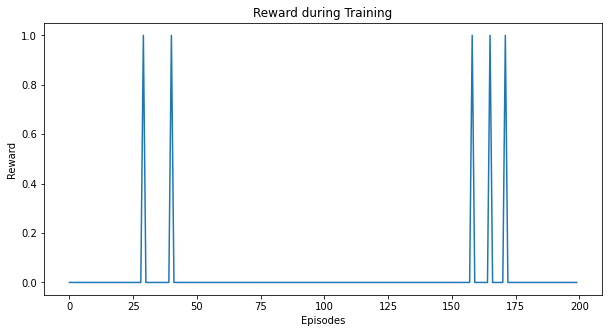

In [23]:
##### Experimental setup #####
episodes = 200
epsilon = 1.0
eps_decay = 0.99
learning_rate = 0.01
discount_factor = 0.999
success_percent_threshold = 20 # in percent, so 60 = 60%

model = define_model(learning_rate, num_actions, num_states)

#### TRAINING #####
train_agent(env, model, episodes, epsilon, discount_factor, eps_decay,
            success_percent_threshold)

### <font color='darkgreen'>Solution (expand to view code)</font>

The following code typically crosses a success rate of 20% in <2000 episodes. In the next cell, you'll visualize the trained agent solving the environment.

Episode: 0020, Success:  9%, Avg length: 07, Epsilon: 0.01
Episode: 0040, Success: 23%, Avg length: 15, Epsilon: 0.01
Episode: 0060, Success: 36%, Avg length: 25, Epsilon: 0.01
Episode: 0080, Success: 49%, Avg length: 33, Epsilon: 0.01
Episode: 0100, Success: 65%, Avg length: 40, Epsilon: 0.01
Agent crossed success threshold of 50%.
Training time (min): 6.36


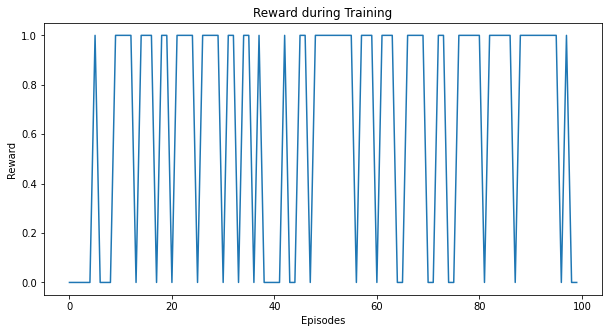

In [37]:
##### Proposed setup #####
episodes = 3000
epsilon = 1.0
eps_decay = 0.9
learning_rate = 0.2
discount_factor = 0.99
success_percent_threshold = 50 # in percent, so 60 = 60%

# model = define_model(learning_rate, num_actions, num_states)

#### TRAINING #####
train_agent(env, model, episodes, epsilon, discount_factor, eps_decay,
            success_percent_threshold)

While Frozen Lake is a more complex environment than NChain, it is simple in comparison to environments such as Pong and Breakout. When solving more and more complex environments, apply the intuition gained from solving simpler environments by using the following guidelines:

* The agent will take longer to find a successful path through random exploration. Therefore, epsilon must decay slower so that the agent explores for longer.
* The agent must use a deeper and wider neural network to approximate the increased complexity.
* The agent must train at a lower learning rate to adapt to the increased complexity.


<a id='sect5'></a>
## <font color='darkblue'>Visualize Performance of Trained Model</font> ([back](#sect0))

Seeing the metrics plots is one thing, but visualizing your agent succeed at retrieving the frisbee is another. Run the following code to visualize your agent solve `FrozenLake`:

In [33]:
from IPython.display import clear_output # to clear output on every episode run

state = env.reset()
done = False
while(not(done)):
    q_values = model.predict(np.identity(num_states)[state:state+1])
    action = np.argmax(q_values)
    state_new, reward, done,_ = env.step(action)
    state = state_new
    clear_output()
    env.render()
    time.sleep(0.5)

  (Down)
SFFF
FHFH
FFFH
HFFG


<a id='sect6'></a>
## <font color='darkblue'>Conclusion and Next Steps</font> ([back](#sect0))

You learned how to combine neural networks with traditional reinforcement learning approaches to solve a simple environment.

Move onto the next Colab: [Experience Replay and Target Networks](https://colab.research.google.com/drive/1DEv8FSjMvsgCDPlOGQrUFoJeAf67cFSo#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-experience-replay-and-target-networks).

For reference, the sequence of course Colabs is as follows:

1. [Problem Framing in Reinforcement Learning](https://colab.research.google.com/drive/1sUYro4ZyiHuuKfy6KXFSdWjNlb98ZROd#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-problem-framing)
1. [Q-learning Framework](https://colab.research.google.com/drive/1ZPsEEu30SH1BUqUSxNsz0xeXL2Aalqfa#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-q-learning)
1. [Tabular Q-Learning](https://colab.research.google.com/drive/1sX2kO_RA1DckhCwX25OqjUVBATmOLgs2#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-tabular-q-learning)
1. [Deep Q-Learning](https://colab.research.google.com/drive/1XnFxIE882ptpO83mcAz7Zg8PxijJOsUs#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-deep-q-learning)
1. [Experience Replay and Target Networks](https://colab.research.google.com/drive/1DEv8FSjMvsgCDPlOGQrUFoJeAf67cFSo#forceEdit=true&sandboxMode=true?utm_source=ss-reinforcement-learning&utm_campaign=colab-external&utm_medium=referral&utm_content=rl-experience-replay-and-target-networks)